In [1]:
import pandas as pd
import numpy as np

# 신한카드 내국인 데이터 전처리 (NATIVE_RE.txt)

In [5]:
df = pd.read_csv("NATIVE_RE.txt", encoding = "utf-8-sig", sep = "|")

/Users/seong-yeseul/miniforge3/envs/atf24/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df.isnull().sum()

v1                256988
v2                     0
v3                     0
gb3                    0
gb2                    0
sex_ccd                0
cln_age_r              0
ta_ym                  0
daw_ccd_r              0
apv_ts_dl_tm_r         0
vlm                    0
usec                   0
dtype: int64

In [8]:
#혹시 결측치가 다른 기호로 표시되어 있을 가능성 염두에 둠 > 없어 보임
print(df.query("v1 == '*'").shape[0])
print(df.query("v2 == '*'").shape[0])
print(df.query("v3 == '*'").shape[0])
print(df.query("sex_ccd == '*'").shape[0])
print(df.query("gb3 == '*'").shape[0])
print(df.query("gb2 == '*'").shape[0])
print(df.query("cln_age_r == '*'").shape[0])
print(df.query("daw_ccd_r == '*'").shape[0])

0
0
0
0
0
0
0
0


In [9]:
#17개 시도에 해당하지 않는 지역명이 들어갔을 가능성 염두에 둠 > 없어 보임
state = ["서울", "부산", "대구", "인천", "광주", "대전","울산", "세종", "경기", "강원", "충북", "충남", "전북", "전남", "경북", "경남", "제주"]
df[np.where(df["v2"].isin(state), False, True)]["v2"].value_counts()

Series([], Name: v2, dtype: int64)

In [ ]:
#변수설명에 맞지 않는 값이 있는지 확인 > 없어 보임
print(df["v1"].value_counts())
print(df["v2"].value_counts())
print(df["sex_ccd"].value_counts())
print(df["cln_age_r"].value_counts())
print(df["daw_ccd_r"].value_counts())
print(df["apv_ts_dl_tm_r"].value_counts())

In [ ]:
#v1에 존재하는 결측값에 일정한 패턴이 있는지 확인
#다른 변수와 결측값의 상관관계는 없어 보임.
#전반적으로 원 데이터셋의 분포와 결측값의 분포가 비례
print(df[df["v1"].isnull()]["v2"].value_counts())
print(df[df["v1"].isnull()]["v3"].value_counts())
print(df[df["v1"].isnull()]["gb2"].value_counts())
print(df[df["v1"].isnull()]["gb3"].value_counts())
print(df[df["v1"].isnull()]["cln_age_r"].value_counts())
print(df[df["v1"].isnull()]["sex_ccd"].value_counts())
print(df[df["v1"].isnull()]["daw_ccd_r"].value_counts())
print(df[df["v1"].isnull()]["apv_ts_dl_tm_r"].value_counts())

In [15]:
#총 결측치가 존재하는 행이 전체의 0.4%에 불과
#missing 값에 어떠한 패턴이 발생하지는 않는 것 같음
df = df.dropna(how = "any")

In [28]:
#분석에 사용할 변수만 남기고 삭제
df = df.loc[:, ["v1", "v2", "v3", "gb2", "ta_ym", "vlm", "usec"]]

In [29]:
#Spotfier 및 시계열 분석에 용이한 형태로 변환
df.loc[:, "time"] = df.copy().loc[:, "ta_ym"].apply(lambda x: str(x)[:4] + "," + str(x)[4:])

In [31]:
df.drop("ta_ym", axis = 1, inplace = True)

In [35]:
#카드 결제지역과 거주지가 다른 경우 이동(여행)이 일어났다고 보아 1, 같은 경우 0
df["tour"] = np.where(df["v1"] != df["v2"], 1, 0)

In [40]:
#지역별 분포 확인시 세부지역의 경우 겹치는 지역명이 있어 하나의 변수로 통합
df["v23"] = df["v2"] + "/" + df["v3"]

In [54]:
#주제에 맞게 진행(비수도권 only)
df = df.query("v2 != '서울' & v2 != '경기'")

In [55]:
#전체 전처리 데이터 "total.csv"로 저장
df.reset_index(drop = True).to_csv("total.csv", encoding = "utf-8-sig")

In [ ]:
#시계열 분석에 용이하게끔 전처리
#우선 카드사용지역(v23), 업종 소분류(gb2), 이동 여부(tour), time 열로 그룹화, 해당 그룹의 결제액 및 결제건수 sum
df_grp = df.drop(["v1", "v2", "v3"], axis = 1).groupby(["v23", "gb2", "tour", "time"]).agg({"vlm" : [np.sum], "usec" : [np.sum]}).reset_index()
df_grp

In [57]:
#그룹화한 데이터 "native_group.csv"로 저장
df_grp.to_csv("native_group.csv", encoding = "utf-8-sig")

## 위의 "native_group.csv" 데이터를 R에서 spread한 버전("spread_r.R"파일 참고) : "usec_ts.csv", "vlm_ts.csv"

In [58]:
usec = pd.read_csv("/Users/seong-yeseul/Downloads/usec_ts.csv", encoding = 'utf-8-sig').drop("Unnamed: 0", axis = 1)
vlm = pd.read_csv("/Users/seong-yeseul/Downloads/vlm_ts.csv", encoding = 'utf-8-sig').drop("Unnamed: 0", axis = 1)

In [59]:
#그룹화 후 sum해서 시간 기준으로 퍼트린 데이터 특성상, 여기서의 결측값은 해당 그룹 조건에 맞는 observation이 존재하지 않는 것.
#따라서 모든 결측값을 0으로 치환해줌
print(usec.isnull().sum())
print(vlm.isnull().sum())

v23           0
gb2           0
tour          0
2017,01     991
2017,02     983
2017,03     883
2017,04     849
2017,05     818
2017,06     819
2017,07     825
2017,08     796
2017,09     788
2017,10     791
2017,11     879
2017,12     920
2018,01    1013
2018,02     990
2018,03     798
2018,04     804
2018,05     751
2018,06     780
2018,07     801
2018,08     790
2018,09     775
2018,10     781
2018,11     781
2018,12     902
2019,01     874
2019,02     891
2019,03     776
2019,04     779
2019,05     711
2019,06     743
2019,07     697
2019,08     695
2019,09     740
2019,10     716
2019,11     729
2019,12     788
2020,01     835
2020,02     918
2020,03    1052
2020,04     963
2020,05     777
2020,06     772
2020,07     775
2020,08     777
2020,09     885
2020,10     771
2020,11     809
2020,12     981
2021,01    1014
2021,02     910
2021,03     803
2021,04     773
2021,05     750
dtype: int64
v23           0
gb2           0
tour          0
2017,01     991
2017,02     983
2017,03    

In [104]:
#위 데이터의 결측치는 결측된 값이 아님
#데이터의 형식을 바꿔주면서 원본 데이터에 해당 그룹의 해당 기간 관측값이 존재하지 않는데 셀을 채워야 하기 때문에 발생
#따라서 해당 그룹의 해당 기간 결제액/결제건수가 없다는 의미로 0으로 치환
usec.fillna(0, inplace = True)
vlm.fillna(0, inplace = True)

# 신한카드 군집별 시계열 분석

In [89]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [71]:
df0 = pd.DataFrame(pd.read_csv("/Users/seong-yeseul/Downloads/v23gb2_cluster0.csv", encoding = "utf-8-sig").iloc[:, 3:56].median(axis = 0))
df1 = pd.DataFrame(pd.read_csv("/Users/seong-yeseul/Downloads/v23gb2_cluster1.csv", encoding = "utf-8-sig").iloc[:, 3:56].median(axis = 0))
df2 = pd.DataFrame(pd.read_csv("/Users/seong-yeseul/Downloads/v23gb2_cluster2.csv", encoding = "utf-8-sig").iloc[:, 3:56].median(axis = 0))

In [77]:
pd.concat([df0, df1, df2], axis = 1).transpose().reset_index(drop = True).to_csv("arima_median.csv", encoding = "utf-8-sig")

## 각 군집별 분석 및 예측 (각 군집별 대표값 Median 사용)

In [79]:
#cluster median data
df = pd.read_csv("arima_median.csv", encoding = 'utf-8-sig').drop("Unnamed: 0", axis = 1)
df0 = df.iloc[0, :].reset_index()
df1 = df.iloc[1, :].reset_index()
df2 = df.iloc[2, :].reset_index()

df0["index"] = pd.to_datetime(df0["index"], format = "%Y,%m").dt.to_period("m")
df0['index'] = df0['index'].dt.strftime('%Y-%m').add('-01 00:00:00.000')
df1["index"] = df0["index"]
df2["index"] = df0["index"]

df0.rename(columns = {"index" : "ds", 0 : "y"}, inplace = True)
df1.rename(columns = {"index" : "ds", 1 : "y"}, inplace = True)
df2.rename(columns = {"index" : "ds", 2 : "y"}, inplace = True)

Text(0.5, 1.0, 'cluster2 median')

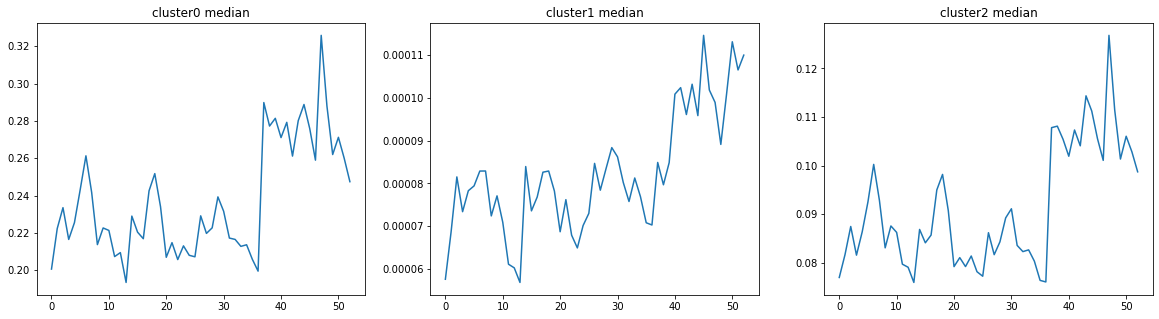

In [86]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].plot(df0["y"])
ax[0].set_title("cluster0 median")
ax[1].plot(df1["y"])
ax[1].set_title("cluster1 median")
ax[2].plot(df2["y"])
ax[2].set_title("cluster2 median")

In [87]:
#median data : range(0, 1)
df0["cap"] = 1
df0["floor"] = 0
df1["cap"] = 1
df1["floor"] = 0
df2["cap"] = 1
df2["floor"] = 0

In [93]:
#cv
def mse_score(df, period, s_mode, c_scale, s_scale, growth):
    idx = list(itertools.product(s_mode, c_scale, s_scale, growth))
    out = {}
    n = df.shape[0]
    for id in idx:
        #print(id)
        try:
            m = Prophet(yearly_seasonality = 12,
                        weekly_seasonality = False, 
                        daily_seasonality = False,
                        seasonality_mode = id[0],
                        changepoint_prior_scale = id[1], 
                        seasonality_prior_scale = id[2], 
                        growth = id[3]).fit(df)
            forecast = m.predict(df[-period:].drop("y", axis = 1))
            fore = forecast["yhat"]
            real = df["y"][-period:].reset_index(drop = True)
            out[id] = mean_squared_error(fore, real)
            #print(out[id])
        except:
            np.nan
    return out

### 평가지표 : MAPE(Mean Absolute Prediction Error), MSPE(Mean Squared Prediction Error)
### Prophet은 파라미터 및 모델 성능을 평가할 수 있는 구체적인 metric이 내장되어 있지 않음 > SARIMA와 최종 모델 비교 위해

$$MAPE = \frac{1}{m}{\sum_{t = N}^{N + m - 1}} \left\lvert \frac{X_{t + 1} - \hat X_{t + 1}}{X_{t+1}} \right\rvert$$

In [88]:
#vlm데이터에 조금 더 적합할듯.
#코드 안의 주석처리된 print 부분은 처음 시범삼아 파라미터 몇 개만 넣고 돌려볼때 정상작동하는지 프린트 위해 넣은 것!
#코로나 이전 시점까지의 데이터로 이후 시점 예측
def mape_accuracy(df, period, s_mode, c_scale, s_scale, growth):
    idx = list(itertools.product(s_mode, c_scale, s_scale, growth))
    out = {}
    n = df.shape[0]
    for id in idx:
        #print(id)
        try:
            m = Prophet(yearly_seasonality = 12,
                        weekly_seasonality = False, 
                        daily_seasonality = False,
                        seasonality_mode = id[0],
                        changepoint_prior_scale = id[1], 
                        seasonality_prior_scale = id[2], 
                        growth = id[3]).fit(df)
            forecast = m.predict(df[-period:].drop("y", axis = 1))
            fore = forecast["yhat"]
            real = df["y"][-period:].reset_index(drop = True)
            out[id] = (1 - (abs((fore - real) / real)).mean())*100
            #print(out[id])
        except:
            np.nan
    return out

$$MSPE = \frac{1}{m}{\sum_{t = N}^{N + m - 1} (X_{t + 1} - \hat X_{t + 1})^2}$$

In [90]:
#1-step-ahead out of sample error
def out_error(data, g, sm, m = 37, ys = 12, ws = False, ds = False, cps = 0.2, sps = 1):
    n = data.shape[0]
    yhat = []
    future = pd.DataFrame(["2020-02-01", "2020-03-01", "2020-04-01", 
                       "2020-05-01", "2020-06-01", "2020-07-01", 
                       "2020-08-01", "2020-09-01", "2020-10-01", 
                       "2020-11-01", "2020-12-01", "2021-01-01", 
                       "2021-02-01", "2021-03-01", "2021-04-01", 
                       "2021-05-01"], columns = ["ds"]).astype("datetime64[ns]")
    for i in range(n-m):
        model = Prophet(yearly_seasonality = ys, seasonality_mode = sm,
           weekly_seasonality = ws, daily_seasonality = ds, changepoint_prior_scale = cps, 
           seasonality_prior_scale = sps, growth = g)
        model.fit(data[:m + i])
        fut = pd.DataFrame(future.iloc[i, :]).transpose()
        fut["floor"] = data["floor"][0]
        fut["cap"] = data["cap"][0]
        forecast = model.predict()["yhat"][0]
        yhat.append(forecast)
    err = (yhat - data.loc[m:, "y"].reset_index(drop = True))**2
    print(np.mean(err))

## 1. 군집 0

In [94]:
out0_mse = mse_score(df = df0, period = 16, s_mode = ["additive", "multiplicative"], c_scale = [0.1, 0.15, 0.2],
              s_scale = [0.5, 1], growth = ["linear", "logistic"])
out0_mape = mape_accuracy(df = df0, period = 16, s_mode = ["additive", "multiplicative"], c_scale = [0.1, 0.15, 0.2],
              s_scale = [0.5, 1], growth = ["linear", "logistic"])
display(pd.DataFrame(out0_mse.values(), index = out0_mse.keys()).sort_values(by = 0).head())
display(pd.DataFrame(out0_mape.values(), index = out0_mape.keys()).sort_values(ascending = False, by = 0).head())

0
multiplicative 0.20 1.0 linear  0.000154
               0.15 1.0 linear  0.000157
               0.10 1.0 linear  0.000158
               0.20 0.5 linear  0.000159
               0.15 0.5 linear  0.000160

0
multiplicative 0.15 1.0 linear  96.382719
               0.10 1.0 linear  96.366875
               0.20 0.5 linear  96.365502
               0.15 0.5 linear  96.353214
               0.10 0.5 linear  96.323588

In [ ]:
out_error(df0, sm = "multiplicative", g = "linear")

### 선택된 모델의 MSE는 0.000154, (1 - MAPE)*100%(정확도)는 96.382719% (SARIMA : 77.84295%)
### SARIMA와 비교하기 위한 out-of-sample MSE는 0.002006821761817018
### 최종 SARIMA out-of-sample MSE : 0.002898187
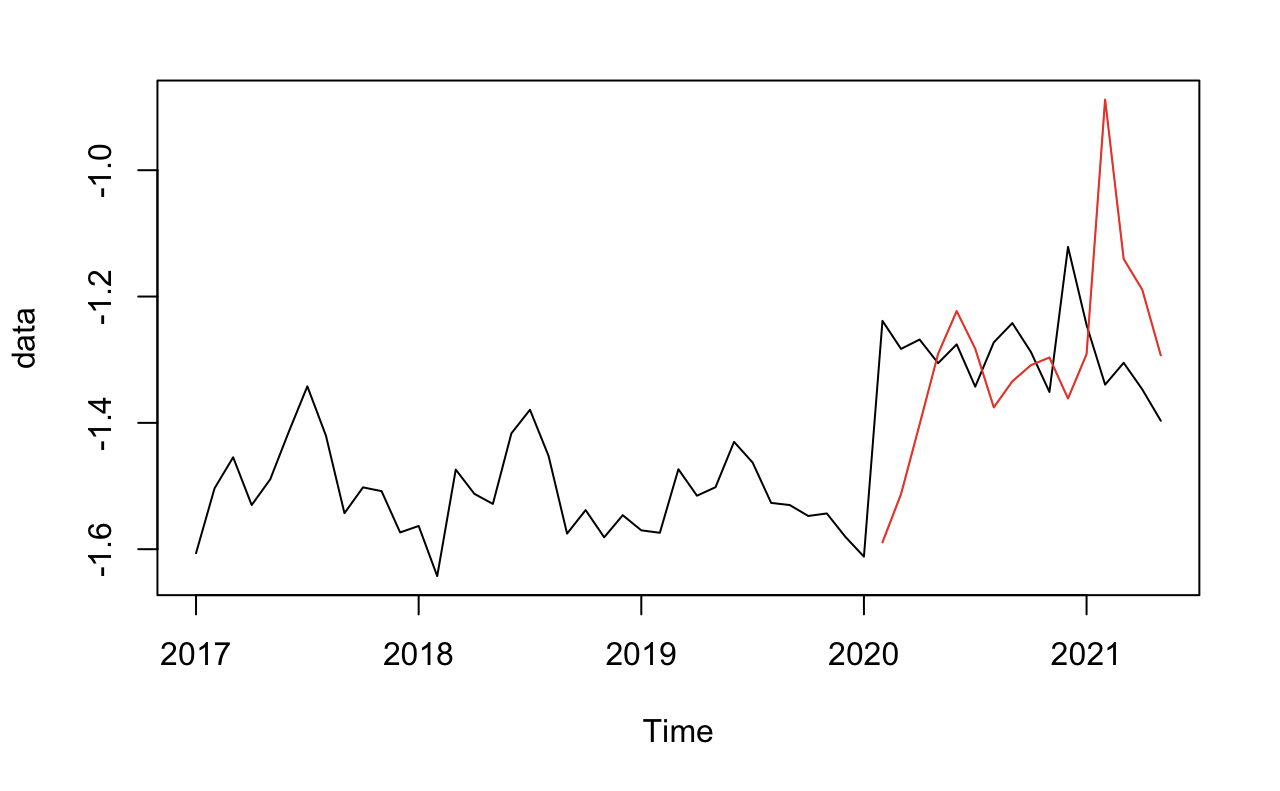
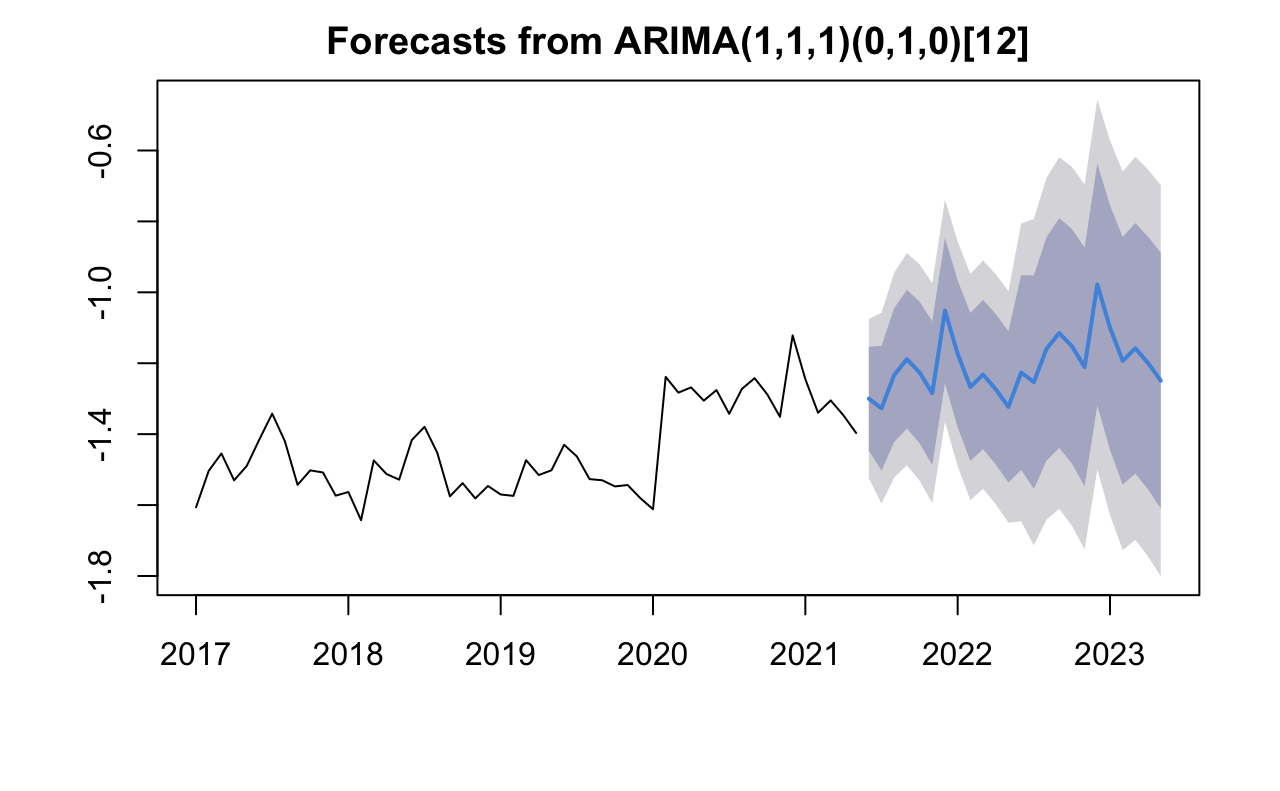
#### seasonality_mode = "multiplicative"
#### changepoint_prior_scale = 0.2
#### seasonality_prior_scale = 1
#### growth = "linear"

In [ ]:
#실제 데이터 vs 모델 예측값(코로나 이후 시기)
m = Prophet(yearly_seasonality = 12, seasonality_mode = "multiplicative",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "linear")
m.fit(df0)
forecast = m.predict(df0[-16:].drop("y", axis = 1))
plt.figure(figsize = (20, 10))
plt.plot(range(53), df0["y"], label = "real")
plt.plot(range(37, 53), forecast["yhat"], label = "prediction")
plt.fill_between(range(37, 53), forecast.loc[:, "yhat_lower"], 
                 forecast.loc[:, "yhat_upper"], color = "lightsteelblue", label = "model_95%")
plt.legend()
plt.title("model prediction vs real obs")
plt.show()

#일반적인 forecast plot

m = Prophet(yearly_seasonality = 12, seasonality_mode = "multiplicative", 
            weekly_seasonality = False, daily_seasonality = False, 
            changepoint_prior_scale = 0.2, seasonality_prior_scale = 1, 
            growth = "linear", interval_width = 0.95)

m.fit(df0)
past = m.make_future_dataframe(periods = 0, freq = "M")
future = pd.DataFrame(["2021-06-01", "2021-07-01", "2021-08-01",
                      "2021-09-01", "2021-10-01", "2021-11-01",
                      "2021-12-01", "2022-01-01", "2022-02-01",
                      "2022-03-01", "2022-04-01", "2022-05-01"],
                     columns = ["ds"]).astype("datetime64[ns]")
future = pd.concat([past, future], axis = 0)
forecast = m.predict(future)
fig = m.plot(forecast, plot_cap = False)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
forecast.to_csv("forecast_c0.csv", encoding = "utf-8-sig")

In [ ]:
#위의 두 플랏 그냥 합친 것.
m = Prophet(yearly_seasonality = 12, seasonality_mode = "multiplicative",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "linear")
m.fit(df0)
future = pd.DataFrame(["2020-02-01", "2020-03-01", "2020-04-01", 
                       "2020-05-01", "2020-06-01", "2020-07-01", 
                       "2020-08-01", "2020-09-01", "2020-10-01", 
                       "2020-11-01", "2020-12-01", "2021-01-01", 
                       "2021-02-01", "2021-03-01", "2021-04-01", 
                       "2021-05-01", "2021-06-01", "2021-07-01", 
                       "2021-08-01", "2021-09-01", "2021-10-01", 
                       "2021-11-01", "2021-12-01", "2022-01-01", 
                       "2022-02-01", "2022-03-01", "2022-04-01", 
                       "2022-05-01"], columns = ["ds"]).astype("datetime64[ns]")
forecast = m.predict(future)
plt.figure(figsize = (20, 10))
plt.plot(range(53), df0["y"], label = "real")
plt.plot(range(37, 65), forecast["yhat"], label = "prediction")
plt.fill_between(range(37, 65), forecast.loc[:, "yhat_lower"], 
                 forecast.loc[:, "yhat_upper"], color = "lightsteelblue", label = "model_95%")
plt.legend()
plt.title("model prediction vs real obs + future forecast")
idx = np.r_[np.array(df0["ds"].str.split(" ").apply(lambda x: x[0][:7])[:-16]),
 np.array(forecast["ds"].apply(lambda x: str(x).split(" ")[0][:7]))]
plt.xticks(range(65), idx, rotation = 60)
plt.show()

## 2. 군집 1

In [ ]:
out1_mse = mse_score(df = df1, period = 16, s_mode = ["additive", "multiplicative"], c_scale = [0.1, 0.15, 0.2],
              s_scale = [0.5, 1], growth = ["linear", "logistic"])
out1_mape = mape_accuracy(df = df1, period = 16, s_mode = ["additive", "multiplicative"], c_scale = [0.1, 0.15, 0.2],
              s_scale = [0.5, 1], growth = ["linear", "logistic"])
display(pd.DataFrame(out1_mse.values(), index = out1_mse.keys()).sort_values(by = 0).head())
display(pd.DataFrame(out1_mape.values(), index = out1_mape.keys()).sort_values(ascending = False, by = 0).head())

In [ ]:
out_error(df1, sm = "multiplicative", g = "logistic")

### 선택된 모델의 MSE는 8.174835e-12, (1 - MAPE)*100%(정확도)는 97.642591% (SARIMA : 83.17977%)
### SARIMA와 비교하기 위한 out-of-sample MSE는 1.6173429093302948e-09
### (최종 SARIMA : 8.868089e-11)
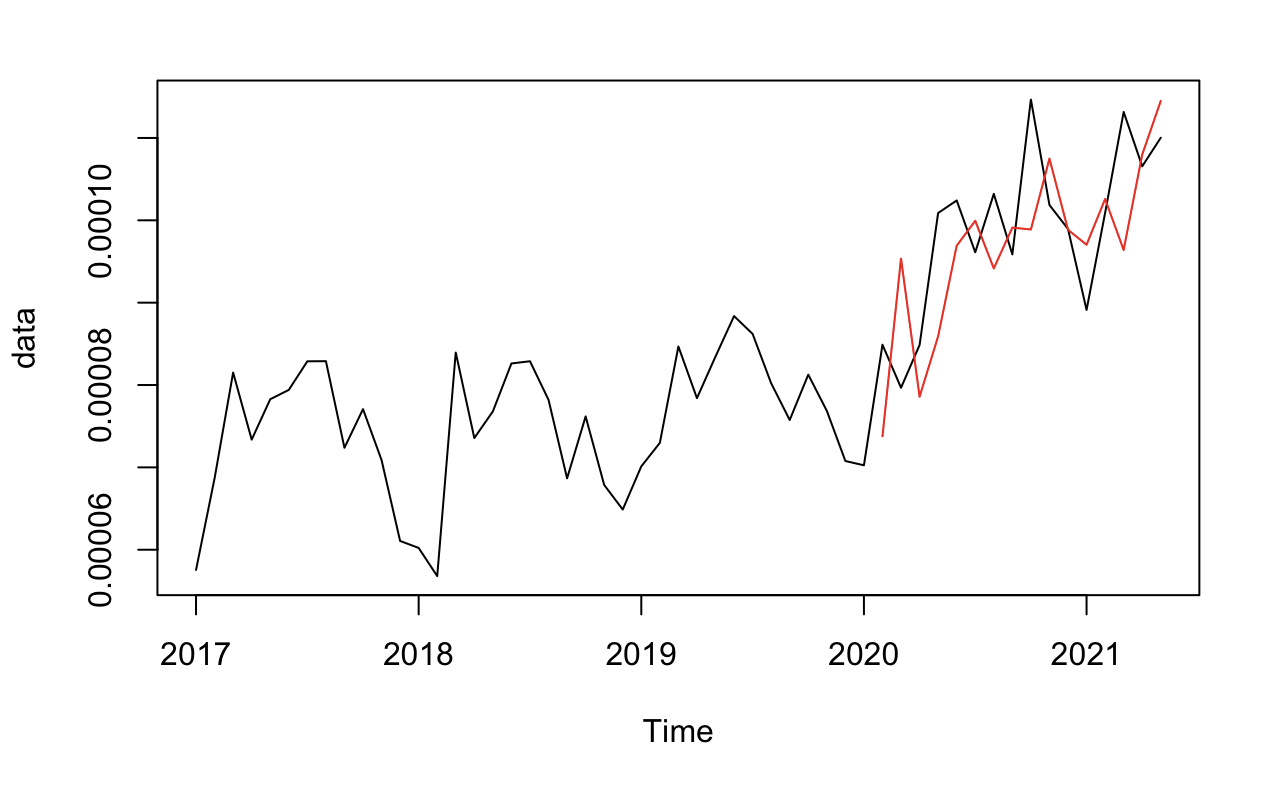
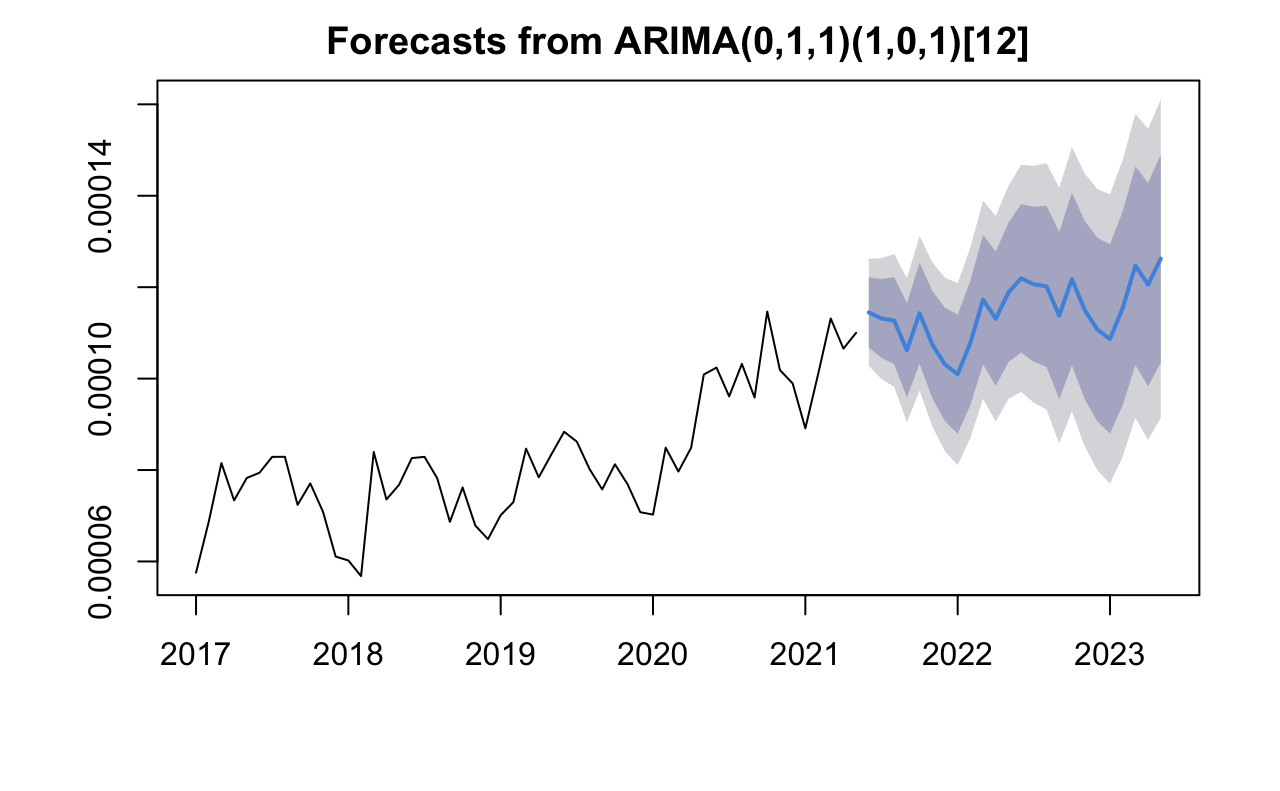
#### seasonality_mode = "multiplicative"
#### changepoint_prior_scale = 0.2
#### seasonality_prior_scale = 1
#### growth = "logistic"

In [ ]:
#실제 데이터 vs 모델 예측값(코로나 이후 시기)
m = Prophet(yearly_seasonality = 12, seasonality_mode = "multiplicative",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "logistic")
m.fit(df1)
forecast = m.predict(df1[-16:].drop("y", axis = 1))
plt.figure(figsize = (20, 10))
plt.plot(range(53), df1["y"], label = "real")
plt.plot(range(37, 53), forecast["yhat"], label = "prediction")
plt.fill_between(range(37, 53), forecast.loc[:, "yhat_lower"], 
                 forecast.loc[:, "yhat_upper"], color = "lightsteelblue", label = "model_95%")
plt.legend()
plt.title("model prediction vs real obs")
plt.show()

#일반적인 forecast plot
m = Prophet(yearly_seasonality = 12, seasonality_mode = "multiplicative",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "logistic")
m.fit(df1)
past = m.make_future_dataframe(periods = 0, freq = "M")
future = pd.DataFrame(["2021-06-01", "2021-07-01", "2021-08-01",
                      "2021-09-01", "2021-10-01", "2021-11-01",
                      "2021-12-01", "2022-01-01", "2022-02-01",
                      "2022-03-01", "2022-04-01", "2022-05-01"],
                     columns = ["ds"]).astype("datetime64[ns]")
future = pd.concat([past, future], axis = 0)
#logistic!
future["floor"] = 0
future["cap"] = 1
forecast = m.predict(future)
fig = m.plot(forecast, plot_cap = False)

In [ ]:
#위의 두 플랏 그냥 합친 것.
m = Prophet(yearly_seasonality = 12, seasonality_mode = "multiplicative",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "logistic")
m.fit(df1)
future = pd.DataFrame(["2020-02-01", "2020-03-01", "2020-04-01", 
                       "2020-05-01", "2020-06-01", "2020-07-01", 
                       "2020-08-01", "2020-09-01", "2020-10-01", 
                       "2020-11-01", "2020-12-01", "2021-01-01", 
                       "2021-02-01", "2021-03-01", "2021-04-01", 
                       "2021-05-01", "2021-06-01", "2021-07-01", 
                       "2021-08-01", "2021-09-01", "2021-10-01", 
                       "2021-11-01", "2021-12-01", "2022-01-01", 
                       "2022-02-01", "2022-03-01", "2022-04-01", 
                       "2022-05-01"], columns = ["ds"]).astype("datetime64[ns]")
future["floor"] = 0
future["cap"] = 1
forecast = m.predict(future)
plt.figure(figsize = (20, 10))
plt.plot(range(53), df1["y"], label = "real")
plt.plot(range(37, 65), forecast["yhat"], label = "prediction")
plt.fill_between(range(37, 65), forecast.loc[:, "yhat_lower"], 
                 forecast.loc[:, "yhat_upper"], color = "lightsteelblue", label = "model_95%")
plt.legend()
plt.title("model prediction vs real obs + future forecast")
idx = np.r_[np.array(df1["ds"].str.split(" ").apply(lambda x: x[0][:7])[:-16]),
 np.array(forecast["ds"].apply(lambda x: str(x).split(" ")[0][:7]))]
plt.xticks(range(65), idx, rotation = 60)
plt.show()

## 3. 군집 2

In [ ]:
out2_mse = mse_score(df = df2, period = 16, s_mode = ["additive", "multiplicative"], c_scale = [0.1, 0.15, 0.2],
              s_scale = [0.5, 1], growth = ["linear", "logistic"])
out2_mape = mape_accuracy(df = df2, period = 16, s_mode = ["additive", "multiplicative"], c_scale = [0.1, 0.15, 0.2],
              s_scale = [0.5, 1], growth = ["linear", "logistic"])
display(pd.DataFrame(out2_mse.values(), index = out2_mse.keys()).sort_values(by = 0).head())
display(pd.DataFrame(out2_mape.values(), index = out2_mape.keys()).sort_values(ascending = False, by = 0).head())

In [ ]:
out_error(df2, sm = "additive", g = "logistic")

### 선택된 모델의 MSE는 0.000011, (1 - MAPE)*100%(정확도)는 97.464451% (SARIMA : 76.47615%)
### SARIMA와 비교하기 위한 out-of-sample MSE는 0.0007999357643285839 
### (최종 SARIMA : 0.0001899338)
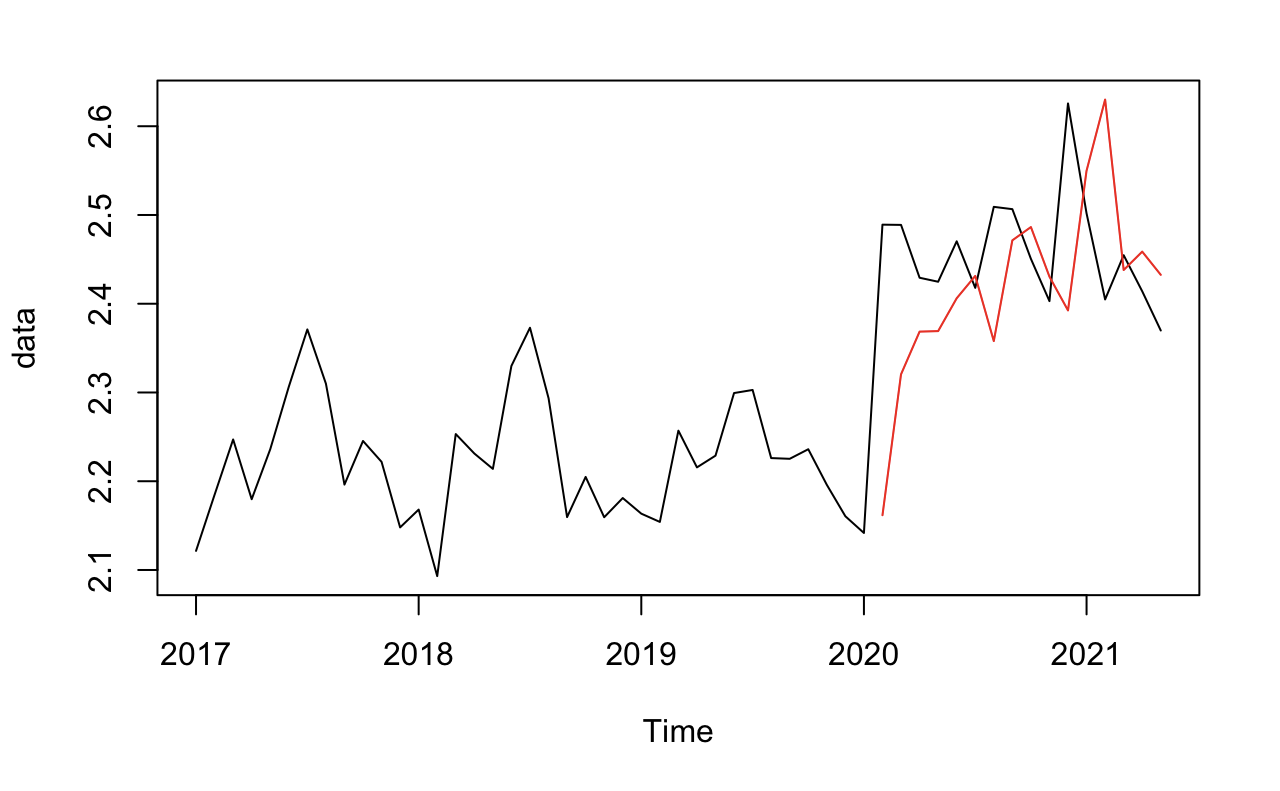
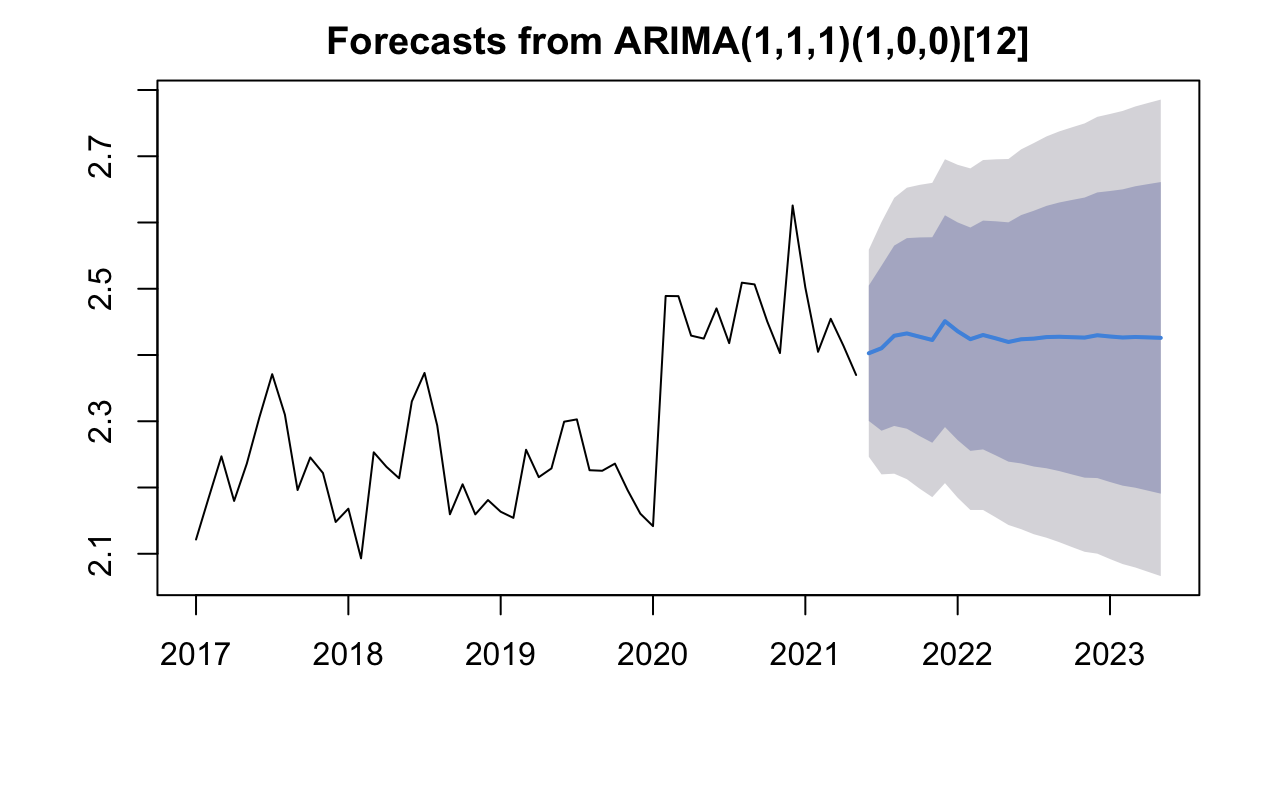
#### seasonality_mode = "additive"
#### changepoint_prior_scale = 0.2
#### seasonality_prior_scale = 1
#### growth = "logistic"

In [ ]:
#실제 데이터 vs 모델 예측값(코로나 이후 시기)
m = Prophet(yearly_seasonality = 12, seasonality_mode = "additive",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "logistic")
m.fit(df2)
forecast = m.predict(df2[-16:].drop("y", axis = 1))
plt.figure(figsize = (20, 10))
plt.plot(range(53), df2["y"], label = "real")
plt.plot(range(37, 53), forecast["yhat"], label = "prediction")
plt.fill_between(range(37, 53), forecast.loc[:, "yhat_lower"], 
                 forecast.loc[:, "yhat_upper"], color = "lightsteelblue", label = "model_95%")
plt.legend()
plt.title("model prediction vs real obs")
plt.show()

#일반적인 forecast plot

m = Prophet(yearly_seasonality = 12, seasonality_mode = "additive",
            weekly_seasonality = False, daily_seasonality = False, 
            changepoint_prior_scale = 0.2, seasonality_prior_scale = 1, 
            growth = "logistic", interval_width = 0.95)

m.fit(df2)
past = m.make_future_dataframe(periods = 0, freq = "M")
future = pd.DataFrame(["2021-06-01", "2021-07-01", "2021-08-01",
                      "2021-09-01", "2021-10-01", "2021-11-01",
                      "2021-12-01", "2022-01-01", "2022-02-01",
                      "2022-03-01", "2022-04-01", "2022-05-01"],
                     columns = ["ds"]).astype("datetime64[ns]")
future = pd.concat([past, future], axis = 0)
future["floor"] = 0
future["cap"] = 1
forecast = m.predict(future)
fig = m.plot(forecast, plot_cap = False)

In [ ]:
forecast.to_csv("forecast_c2.csv", encoding ="utf-8-sig")

In [ ]:
#위의 두 플랏 그냥 합친 것.
m = Prophet(yearly_seasonality = 12, seasonality_mode = "additive",
           weekly_seasonality = False, daily_seasonality = False, changepoint_prior_scale = 0.2, 
           seasonality_prior_scale = 1, growth = "logistic")
m.fit(df2)
future = pd.DataFrame(["2020-02-01", "2020-03-01", "2020-04-01", 
                       "2020-05-01", "2020-06-01", "2020-07-01", 
                       "2020-08-01", "2020-09-01", "2020-10-01", 
                       "2020-11-01", "2020-12-01", "2021-01-01", 
                       "2021-02-01", "2021-03-01", "2021-04-01", 
                       "2021-05-01", "2021-06-01", "2021-07-01", 
                       "2021-08-01", "2021-09-01", "2021-10-01", 
                       "2021-11-01", "2021-12-01", "2022-01-01", 
                       "2022-02-01", "2022-03-01", "2022-04-01", 
                       "2022-05-01"], columns = ["ds"]).astype("datetime64[ns]")
future["floor"] = 0
future["cap"] = 1
forecast = m.predict(future)
plt.figure(figsize = (20, 10))
plt.plot(range(53), df2["y"], label = "real")
plt.plot(range(37, 65), forecast["yhat"], label = "prediction")
plt.fill_between(range(37, 65), forecast.loc[:, "yhat_lower"], 
                 forecast.loc[:, "yhat_upper"], color = "lightsteelblue", label = "model_95%")
plt.legend()
plt.title("model prediction vs real obs + future forecast")
idx = np.r_[np.array(df2["ds"].str.split(" ").apply(lambda x: x[0][:7])[:-16]),
 np.array(forecast["ds"].apply(lambda x: str(x).split(" ")[0][:7]))]
plt.xticks(range(65), idx, rotation = 60)
plt.show()

## 군집별 최종 선택 시계열 모델 시각화 & 분석

In [96]:
#median data
df0 = pd.read_csv("arima_median.csv", encoding = 'utf-8-sig').drop("Unnamed: 0", axis = 1).iloc[0, :].reset_index()
df1 = pd.read_csv("arima_median.csv", encoding = 'utf-8-sig').drop("Unnamed: 0", axis = 1).iloc[1, :].reset_index()
df2 = pd.read_csv("arima_median.csv", encoding = 'utf-8-sig').drop("Unnamed: 0", axis = 1).iloc[2, :].reset_index()

In [98]:
#median data prediction
stats0 = pd.read_csv("forecast_c0.csv", encoding = "utf-8-sig").loc[:, ["ds", "yhat_lower", "yhat_upper", "yhat"]].rename(columns = {"ds" : "time"}).iloc[53:65,].reset_index(drop = True)
stats1 = pd.read_csv("c1_med_011101.csv", encoding = "utf-8-sig").loc[:, ["Unnamed: 0", "yhat", "L95", "U95"]].rename(columns  = {"Unnamed: 0":"time", "L95":"yhat_lower", "U95":"yhat_upper"}).iloc[:12,].reset_index(drop = True)
stats2 = pd.read_csv("forecast_c2.csv", encoding = "utf-8-sig").set_index("Unnamed: 0").loc[:, ["ds", "yhat_lower", "yhat_upper", "yhat"]].rename(columns = {"ds" : "time"}).iloc[53:65,].reset_index(drop = True)

stats0["time"] = stats1["time"]
stats2["time"] = stats1["time"]

In [99]:
#whole original data
c0 = pd.read_csv("v23gb2_cluster0.csv", encoding = "utf-8-sig").iloc[:, 3:56]
c1 = pd.read_csv("v23gb2_cluster1.csv", encoding = "utf-8-sig").iloc[:, 3:56]
c2 = pd.read_csv("v23gb2_cluster2.csv", encoding = "utf-8-sig").iloc[:, 3:56]

## 군집 0 : Prophet(seasonality_mode = "multiplicative", changepoint_prior_scale = 0.2, seasonality_prior_scale = 1, growth = "linear")

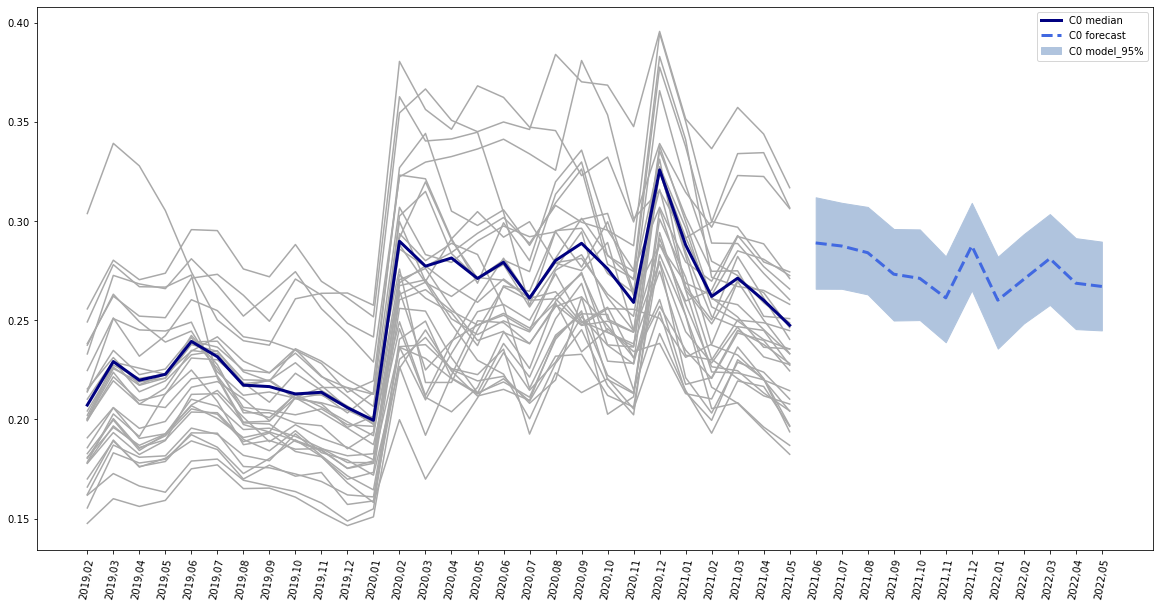

In [100]:
#시각화 결과
#예측값의 추세가 잘 보이게끔 관찰값 범위 제한
for i in range(c0[(c0 < 0.4).sum(axis = 1) == 53].shape[0]):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.plot(range(28), c0[(c0 < 0.4).sum(axis = 1) == 53].iloc[i, 25:], color = "darkgray")
plt.plot(range(28), df0.iloc[25:, 1], color = "navy", label = "C0 median", linewidth = 3)
plt.plot(range(28, 40), stats0["yhat"], color = "royalblue", label = "C0 forecast", linestyle = "--", linewidth = 3)
plt.fill_between(range(28, 40), stats0["yhat_lower"], stats0["yhat_upper"], color = "lightsteelblue", label = "C0 model_95%")
plt.xticks(range(40), np.r_[c0.columns[25:], stats0.time], rotation = 80)
plt.legend()
plt.show()

## 군집 1 : SARIMA(0, 1, 1)(1, 0, 1)[12]

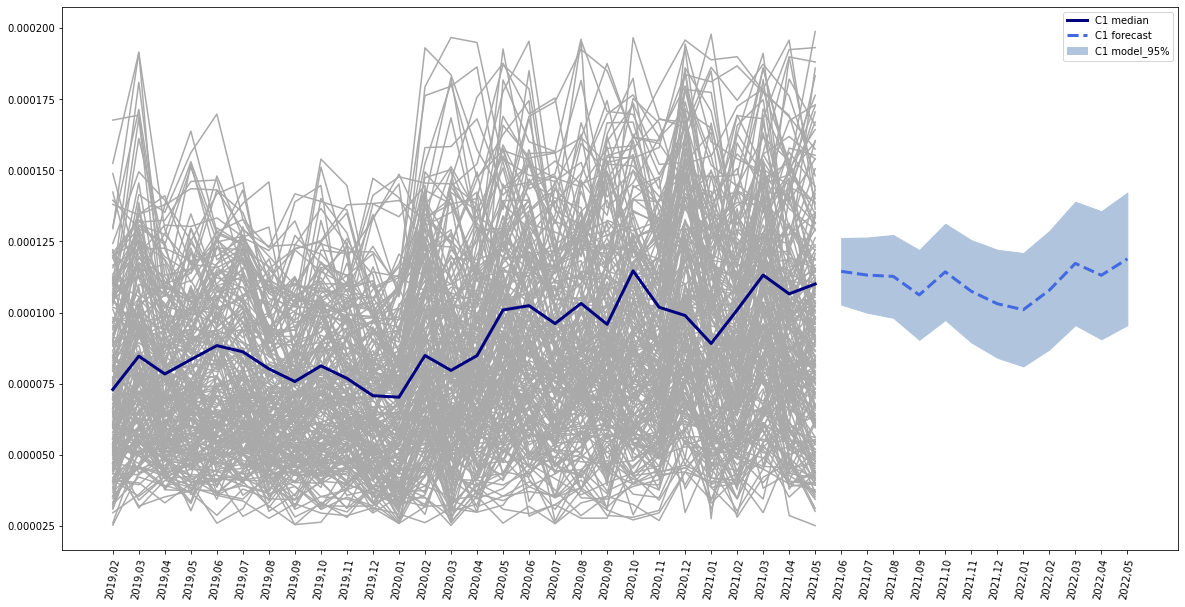

In [101]:
#시각화 결과
#예측값의 추세가 잘 보이게끔 관찰값 범위 제한
for i in range(c1[((c1 < 0.0002) & (c1 > 0.000025)).sum(axis = 1) == 53].shape[0]):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.plot(range(28), c1[((c1 < 0.0002) & (c1 > 0.000025)).sum(axis = 1) == 53].iloc[i, 25:], color = "darkgray")
plt.plot(range(28), df1.iloc[25:, 1], color = "navy", label = "C1 median", linewidth = 3)
plt.plot(range(28, 40), stats1["yhat"], color = "royalblue", label = "C1 forecast", linestyle = "--", linewidth = 3)
plt.fill_between(range(28, 40), stats1["yhat_lower"], stats1["yhat_upper"], color = "lightsteelblue", label = "C1 model_95%")
plt.xticks(range(40), np.r_[c1.columns[25:], stats1.time], rotation = 80)
plt.legend()
plt.show()

## 군집 2 :  Prophet(seasonality_mode = "additive", changepoint_prior_scale = 0.2, seasonality_prior_scale = 1, growth = "logistic")

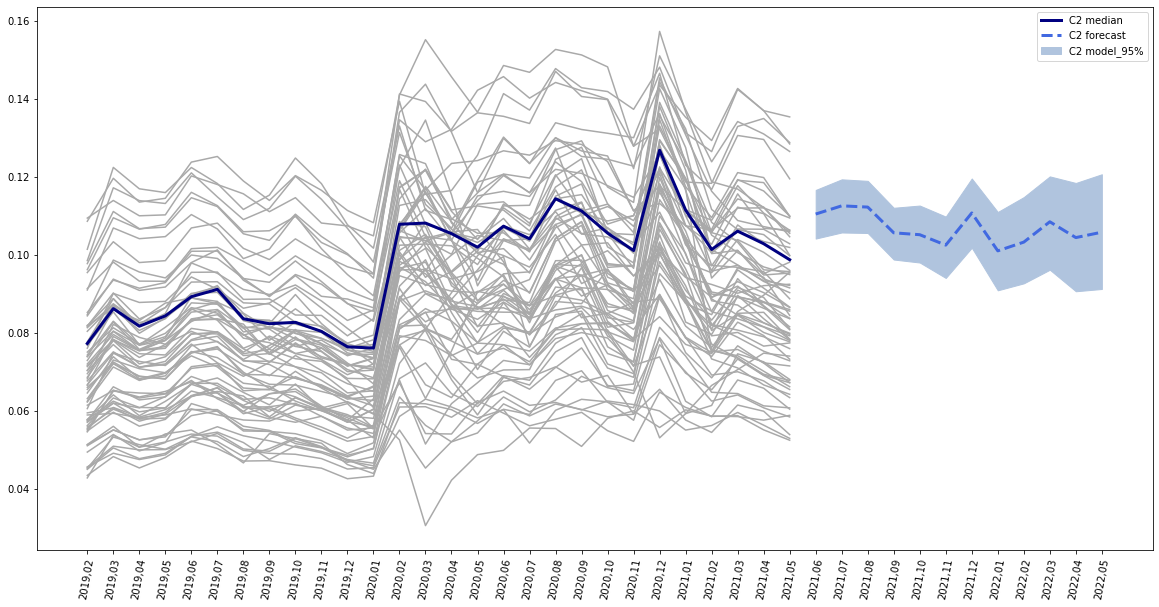

In [102]:
#시각화 결과
#예측값의 추세가 잘 보이게끔 관찰값 범위 제한
for i in range(c2[(c2 < 0.16).sum(axis = 1) == 53].shape[0]):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.plot(range(28), c2[(c2 < 0.16).sum(axis = 1) == 53].iloc[i, 25:], color = "darkgray")
plt.plot(range(28), df2.iloc[25:, 1], color = "navy", label = "C2 median", linewidth = 3)
plt.plot(range(28, 40), stats2["yhat"], color = "royalblue", label = "C2 forecast", linestyle = "--", linewidth = 3)
plt.fill_between(range(28, 40), stats2["yhat_lower"], stats2["yhat_upper"], color = "lightsteelblue", label = "C2 model_95%")
plt.xticks(range(40), np.r_[c2.columns[25:], stats2.time], rotation = 80)
plt.legend()
plt.show()

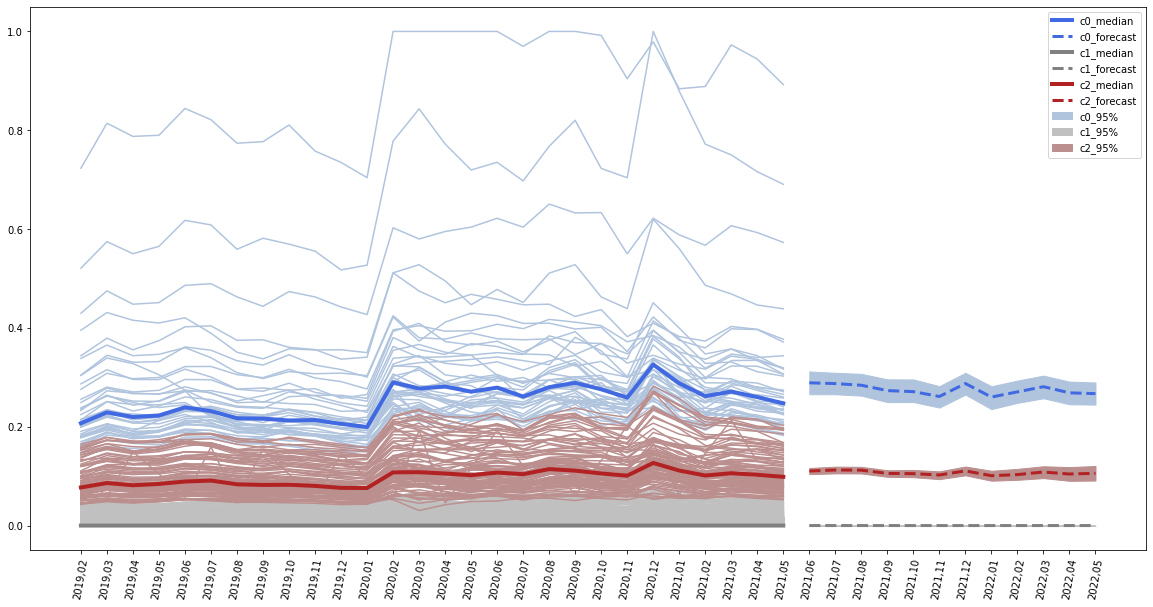

In [103]:
## 클러스터별 비교 한 눈에 가능하게끔
for i in range(c0.shape[0]):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.plot(range(28), c0.iloc[i, 25:], color = "lightsteelblue")
for i in range(c1.shape[0]):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.plot(range(28), c1.iloc[i, 25:], color = "silver")
for i in range(c2.shape[0]):
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.plot(range(28), c2.iloc[i, 25:], color = "rosybrown")
    
plt.plot(range(28), df0.iloc[25:, 1], color = "royalblue", label = "c0_median", linewidth = 4)
plt.plot(range(28, 40), stats0["yhat"], color = "royalblue", label = "c0_forecast", linestyle = "--", linewidth = 3)
plt.fill_between(range(28, 40), stats0["yhat_lower"], stats0["yhat_upper"], color = "lightsteelblue", label = "c0_95%")

plt.plot(range(28), df1.iloc[25:, 1], color = "gray", label = "c1_median", linewidth = 4)
plt.plot(range(28, 40), stats1["yhat"], color = "gray", label = "c1_forecast", linestyle = "--", linewidth = 3)
plt.fill_between(range(28, 40), stats1["yhat_lower"], stats1["yhat_upper"], color = "silver", label = "c1_95%")

plt.plot(range(28), df2.iloc[25:, 1], color = "firebrick", label = "c2_median", linewidth = 4)
plt.plot(range(28, 40), stats2["yhat"], color = "firebrick", label = "c2_forecast", linestyle = "--", linewidth = 3)
plt.fill_between(range(28, 40), stats2["yhat_lower"], stats2["yhat_upper"], color = "rosybrown", label = "c2_95%")

plt.xticks(range(40), np.r_[c2.columns[25:], stats2.time], rotation = 80)
plt.legend()
plt.show()